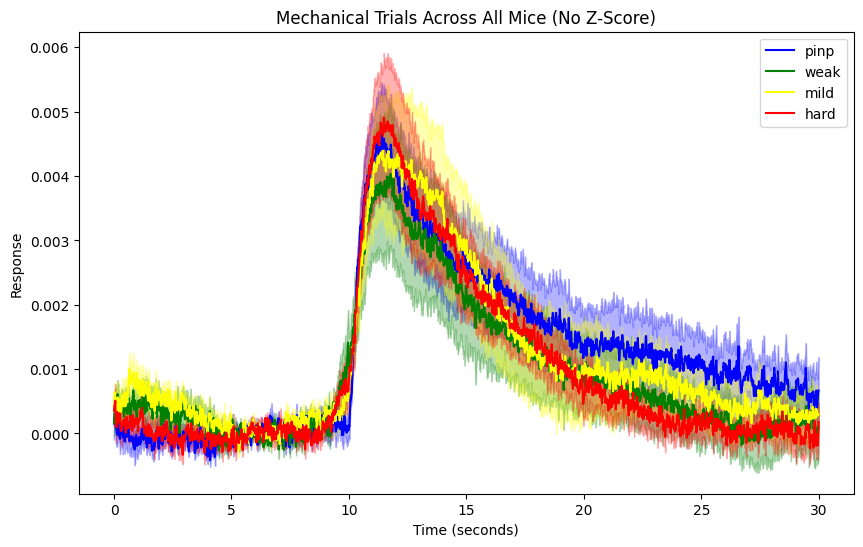

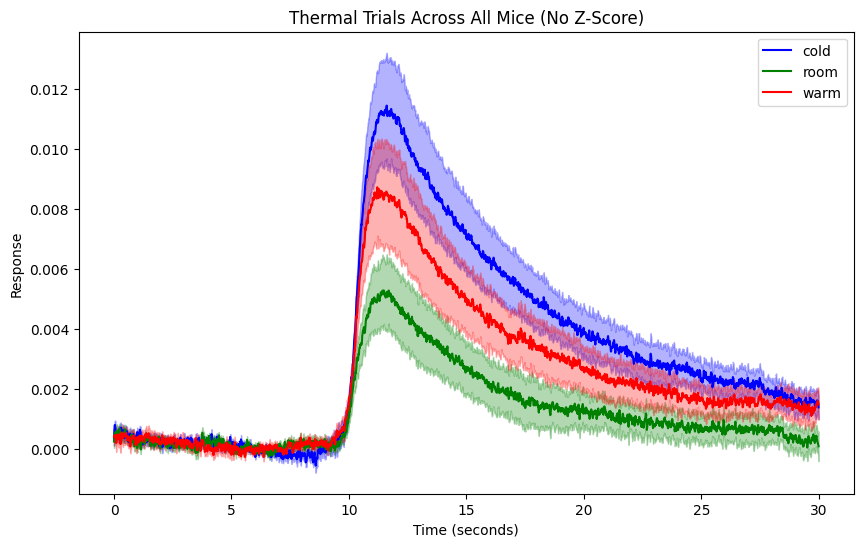

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Path to the uploaded zip file
extract_folder_path = 'E:/sensory_stim/grabda/control/'  # Change this to your desired extraction path

# Loading the data from .npy files
all_data = {animal: np.load(os.path.join(extract_folder_path, animal), allow_pickle=True) 
            for animal in os.listdir(extract_folder_path) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to extract trials for each animal
def extract_trials_per_animal(animal_data, trial_types):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                animal_trials[trial] = data.item()[trial]
        trials[animal] = animal_trials
    return trials

# Extracting trials for each animal
mechanical_data_no_zscore = extract_trials_per_animal(all_data, mechanical_trials)
thermal_data_no_zscore = extract_trials_per_animal(all_data, thermal_trials)

# Function to calculate average and SEM across all animals for each trial type
def calculate_avg_sem_across_animals(data_per_animal, trial_types):
    avg_sem = {}
    for trial in trial_types:
        trial_data = np.array([animal_data[trial] for animal_data in data_per_animal.values() if trial in animal_data])
        avg, sem_val = np.mean(trial_data, axis=0), sem(trial_data, axis=0)
        avg_sem[trial] = (avg, sem_val)
    return avg_sem

# Calculating average and SEM for mechanical and thermal trials
mechanical_avg_sem_no_zscore = calculate_avg_sem_across_animals(mechanical_data_no_zscore, mechanical_trials)
thermal_avg_sem_no_zscore = calculate_avg_sem_across_animals(thermal_data_no_zscore, thermal_trials)

# Defining custom color codes for each trial type
color_codes = {
    'average_trace_cold': 'blue',
    'average_trace_room': 'green',
    'average_trace_warm': 'red',
    'average_trace_pinp': 'blue',
    'average_trace_weak': 'green',
    'average_trace_mild': 'yellow',
    'average_trace_hard': 'red'
}

# Modified plotting function with custom color codes
def plot_trials_with_colors(trial_data, title, sampling_rate, color_codes):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(len(next(iter(trial_data.values()))[0])) / sampling_rate
    for trial, (avg, error) in trial_data.items():
        color = color_codes.get(trial, 'black')  # Default color is black if not specified
        plt.plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        plt.fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

# Plotting the trials
plot_trials_with_colors(mechanical_avg_sem_no_zscore, "Mechanical Trials Across All Mice (No Z-Score)", 130, color_codes)
plot_trials_with_colors(thermal_avg_sem_no_zscore, "Thermal Trials Across All Mice (No Z-Score)", 130, color_codes)


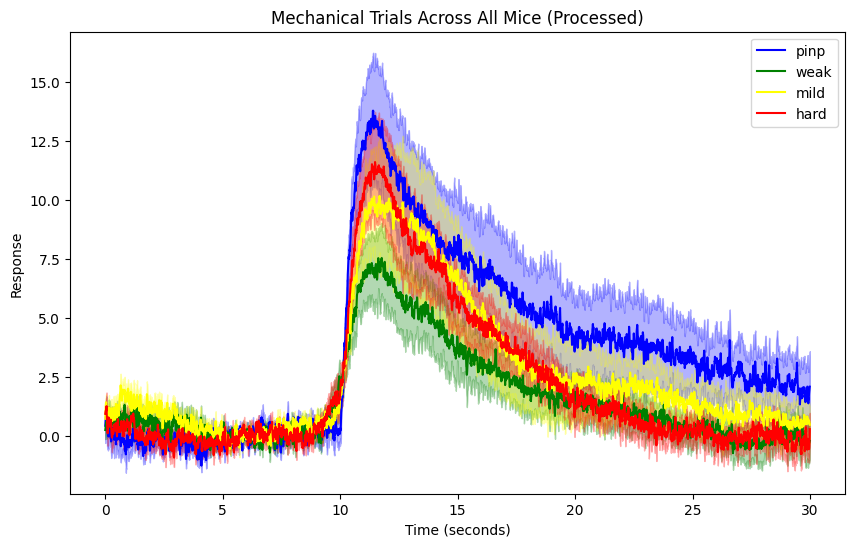

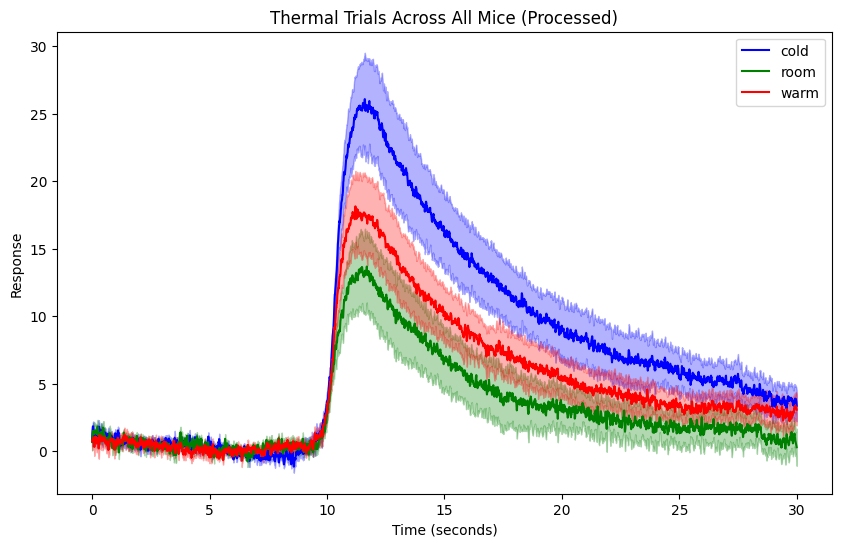

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Path to the uploaded zip file
extract_folder_path = 'E:/sensory_stim/grabda/control/'  # Change this to your desired extraction path

# Loading the data from .npy files
all_data = {animal: np.load(os.path.join(extract_folder_path, animal), allow_pickle=True) 
            for animal in os.listdir(extract_folder_path) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to apply z-score normalization and zero out a specific period
def zscore_and_zero_period(data, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    # Applying z-score normalization with baseline
    baseline_indices = (np.arange(baseline_start, baseline_end, 1/sampling_rate) * sampling_rate).astype(int)
    baseline_mean = np.mean(data[baseline_indices])
    baseline_std = np.std(data[baseline_indices])
    normalized_data = (data - baseline_mean) / baseline_std

    # Zeroing out the specific period
    zero_indices = (np.arange(zero_start, zero_end, 1/sampling_rate) * sampling_rate).astype(int)
    zero_mean = np.mean(normalized_data[zero_indices])
    return normalized_data - zero_mean

# Function to extract, normalize, and zero out trials for each animal
def extract_normalize_zero_trials_per_animal(animal_data, trial_types, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                processed_data = zscore_and_zero_period(data.item()[trial], baseline_start, baseline_end, zero_start, zero_end, sampling_rate)
                animal_trials[trial] = processed_data
        trials[animal] = animal_trials
    return trials

# Extracting, normalizing, and zeroing out trials for each animal
baseline_start_sec = 0  # Starting point of the baseline in seconds
baseline_end_sec = 10   # Ending point of the baseline in seconds
zero_start_sec = 5     # Starting point of zeroing out period in seconds
zero_end_sec = 7       # Ending point of zeroing out period in seconds

mechanical_data_processed = extract_normalize_zero_trials_per_animal(all_data, mechanical_trials, 
                                                                     baseline_start_sec, baseline_end_sec, 
                                                                     zero_start_sec, zero_end_sec, 130)
thermal_data_processed = extract_normalize_zero_trials_per_animal(all_data, thermal_trials, 
                                                                  baseline_start_sec, baseline_end_sec, 
                                                                  zero_start_sec, zero_end_sec, 130)

# Calculating average and SEM for mechanical and thermal trials with processed data
mechanical_avg_sem_processed = calculate_avg_sem_across_animals(mechanical_data_processed, mechanical_trials)
thermal_avg_sem_processed = calculate_avg_sem_across_animals(thermal_data_processed, thermal_trials)

# Plotting the trials with processed data
plot_trials_with_colors(mechanical_avg_sem_processed, "Mechanical Trials Across All Mice (Processed)", 130, color_codes)
plot_trials_with_colors(thermal_avg_sem_processed, "Thermal Trials Across All Mice (Processed)", 130, color_codes)